

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder


## 1.1. Подготовка данных 


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import transforms
import torch
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import gc
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
data   = torch.FloatTensor(data)

In [ ]:
data.shape

torch.Size([13143, 64, 64, 3])

In [ ]:
data = torch.permute(data, (0, 3, 1,2))
data.shape

torch.Size([13143, 3, 64, 64])

In [ ]:
type(data)

torch.Tensor

In [ ]:
attrs.shape

(13143, 73)


Разбью выборку картинок на train и val, и выведу несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)

In [ ]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
train_data.shape

torch.Size([11828, 3, 64, 64])

In [ ]:
gc.collect()

90

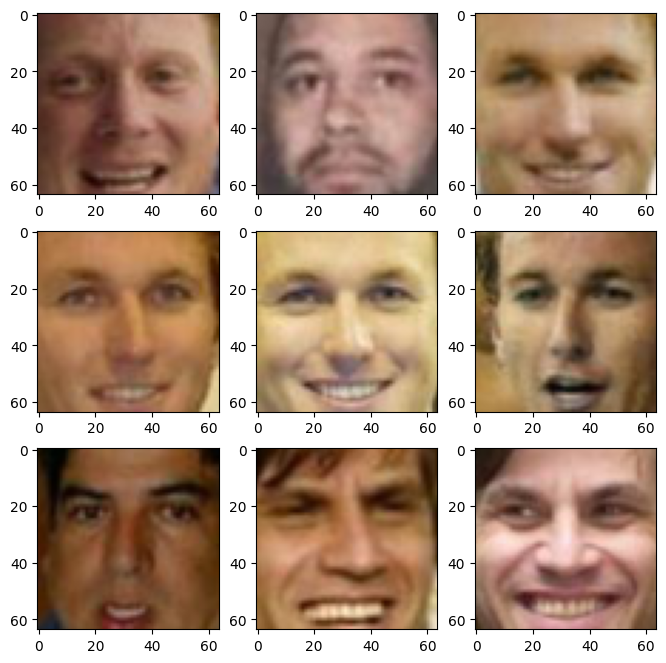

In [ ]:
for i,img in enumerate(train_loader):
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3

  for n in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, n)
    
    plt.imshow(torch.permute(img[n], (1, 2,0)).squeeze())
  plt.show()
  break

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


In [ ]:
dim_code = 16 # выберите размер латентного вектора

In [ ]:
def size_of_conv(Cin,kern=3,dilation=1,stride=1,pad=0):

  size=(Cin+2*pad-dilation*(kern-1)-1)/stride+1
  return size

In [ ]:
size_of_conv(Cin=64,stride=2,)

31.5

In [ ]:
Cin_=28
print('In:',Cin_)
for i in range(5):
  C_out= size_of_conv(Cin=Cin_,stride=2,dilation=2,pad=2)
  print(f'Out:{i+1}',C_out)
  Cin_=C_out

In: 28
Out:1 14.5
Out:2 7.75
Out:3 4.375
Out:4 2.6875
Out:5 1.84375


In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self,dim_code=32):
      super(Autoencoder,self).__init__()
      self.fatures=dim_code
      self.flatten=nn.Flatten()
      self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=2,dilation=3,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32,kernel_size=3, stride=2,dilation=3,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, kernel_size=3, stride=2,dilation=3,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, dim_code, kernel_size=3, stride=2,dilation=3,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(dim_code)

        )
      self.encoder_lin_lat = nn.Sequential(
          nn.Linear(
              in_features=dim_code*3*3,
              out_features=dim_code))
      
      self.dencoder_lin_lat = nn.Sequential(
          nn.Linear(
              in_features=dim_code,
              out_features=dim_code*3*3))
      
      self.decoder = nn.Sequential(
        nn.ConvTranspose2d(dim_code, 64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 255, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(255),
        nn.ConvTranspose2d(255, 64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2),
        )
    
   
        
    def forward(self, x):
      x = self.encoder(x)
      x = self.flatten(x)
      lat = self.encoder_lin_lat(x)
      z = self.dencoder_lin_lat(lat).view(-1,  self.fatures,3,3,)
      x = self.decoder(z)
      return x,lat

    def sample(self, z):
        z = self.dencoder_lin_lat(z).view(-1,  self.fatures,3,3,)
        generated = self.decoder(z)
        return generated

     

 
        

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Обучение


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

In [ ]:
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed,_ = model(X_batch.to(device))
       
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed,_ = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


<ipython-input-15-1edf9f355df1>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

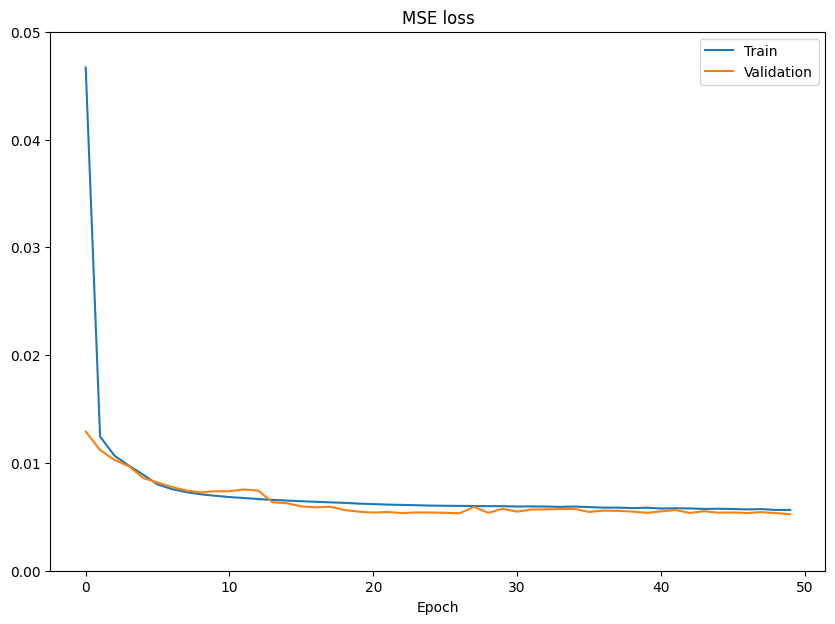

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
  model.eval()
  with torch.no_grad():
      for batch in val_loader:
        reconstruction,lat= model(batch.to(device))
        print(reconstruction.shape)
        result = reconstruction.cpu().detach()
        ground_truth = batch
        break

torch.Size([32, 3, 64, 64])


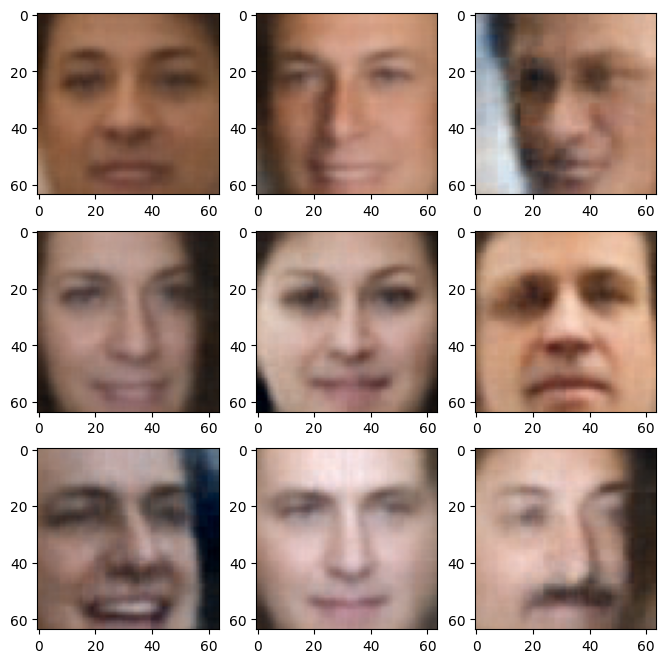

In [ ]:
for i,img in enumerate(result):
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3

  for n in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, n)

    plt.imshow(torch.permute(result[n], (1, 2,0)).squeeze())
  plt.show()
  break

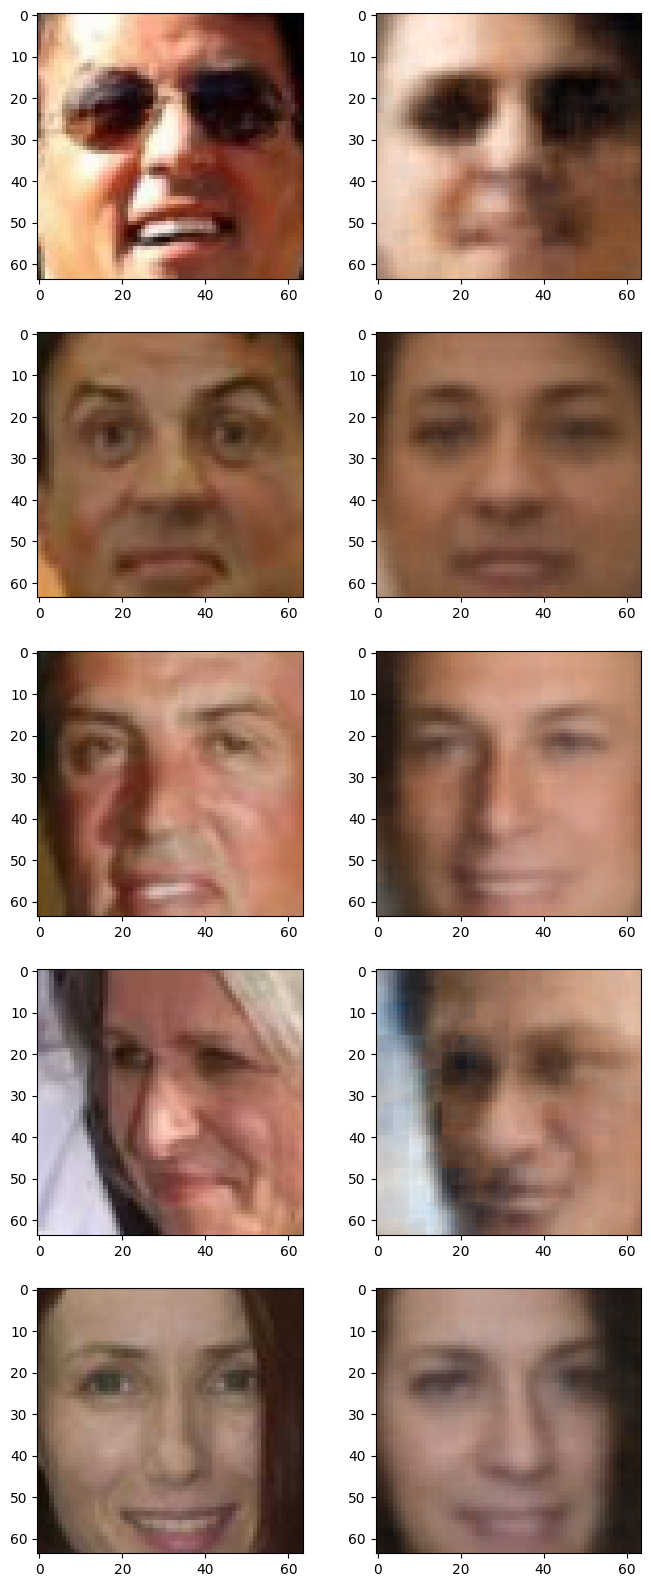

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(torch.permute(gt, (1, 2,0)))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(torch.permute(res, (1, 2,0)))

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:

mu = torch.mean(lat, (0, 1)).item()
sigma = torch.std(lat, (0, 1)).item()
z = np.array([sigma * np.random.normal(0, 1, 32) + mu for i in range(25)])
model.eval()
with torch.no_grad():
  output  = model.sample(torch.FloatTensor(z).to(device))


In [ ]:
np.min(z),np.max(z)

In [ ]:
output.shape[0]

ValueError: ignored

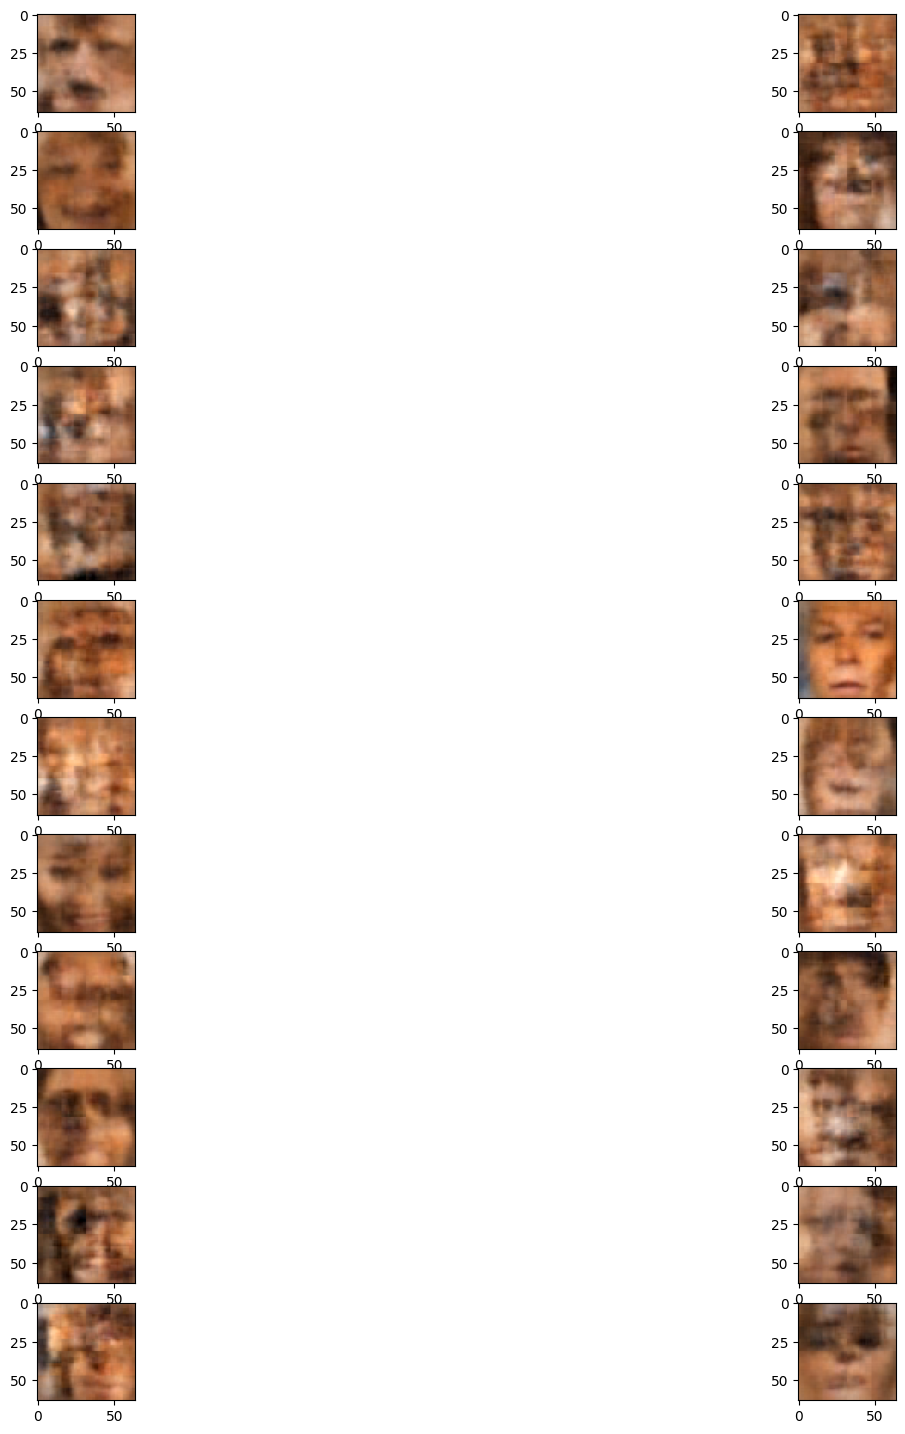

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach()
  plt.imshow(torch.permute(generated, (1, 2,0)))

plt.show()

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_dataset, val_data= train_test_split(train_dataset, 
                                                                    train_size=0.9, shuffle=False)
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 192797904.16it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37678287.35it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65065634.88it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3984632.66it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение

Реализуем VAE.

In [ ]:
class VAE(nn.Module):
    def __init__(self,dim_code=32):
      super(__class__, self).__init__()
      self.fatures=dim_code
      #self.flatten=nn.Flatten()
      self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2,dilation=2,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32,kernel_size=3, stride=2,dilation=2,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, kernel_size=3, stride=2,dilation=2,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, dim_code, kernel_size=3, stride=2,dilation=2,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(dim_code),
        nn.Flatten(),
        nn.Linear(in_features=2*2*dim_code, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=dim_code*2 )
        )
      
      self.decoder = nn.Sequential(
        nn.Linear(in_features=dim_code, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=dim_code*2*2),
        nn.Unflatten(1, (dim_code, 2, 2)),
        nn.ConvTranspose2d(dim_code, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 1, kernel_size=4, stride=1),
        )

    def encode(self, x):
      x = self.encoder(x).view(-1, 2, self.fatures)
      #print('encode shape',x.shape)
      mu = x[:, 0, :] # the first feature values as mean
      logsigma = x[:, 1, :] # the other feature values as variance

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std)       
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
      mu, logsigma = self.encode(x)
      z = self.gaussian_sampler(mu,logsigma)
      #print(z.shape)
      reconstruction = self.decode(z)
      return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
n_epochs = 70
train_losses = []
val_losses = []
mus = torch.Tensor()
labels = torch.Tensor()
for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, (X_batch,Y_batch) in enumerate(train_loader):
        #print('X_batch',X_batch.shape)
        #X_batch = X_batch.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
        #print(reconstruction.shape)
        reconstruction = reconstruction.view(-1,1, 28, 28)
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, (X_batch,Y_batch) in enumerate(val_loader):
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
          reconstruction = reconstruction.view(-1, 1,28,28)
          loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
          if epoch == n_epochs - 1:
            mus = torch.cat((mus, mu.to('cpu')), 0)
            labels = torch.cat((labels, Y_batch), dim=0)

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-226-52157413f9f7>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/70 [00:00<?, ?it/s]

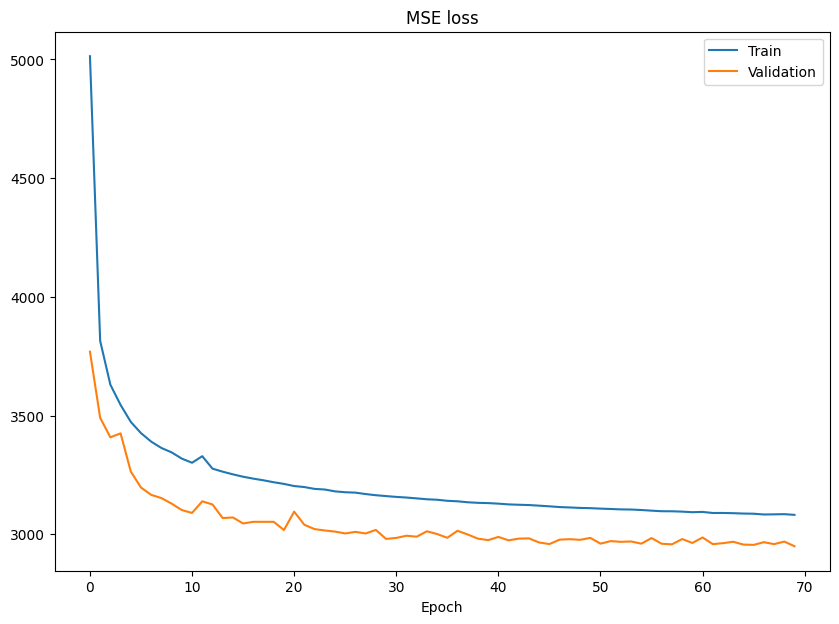

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

#plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
  autoencoder.eval()
  with torch.no_grad():
      for i, (X_batch,Y_batch) in enumerate(test_loader):
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
          print(reconstruction.shape)
          #reconstruction = reconstruction.view( 64, 64, 3)
          result = reconstruction.cpu().detach()#.numpy()
          ground_truth = X_batch#.numpy()
          break

torch.Size([32, 1, 28, 28])


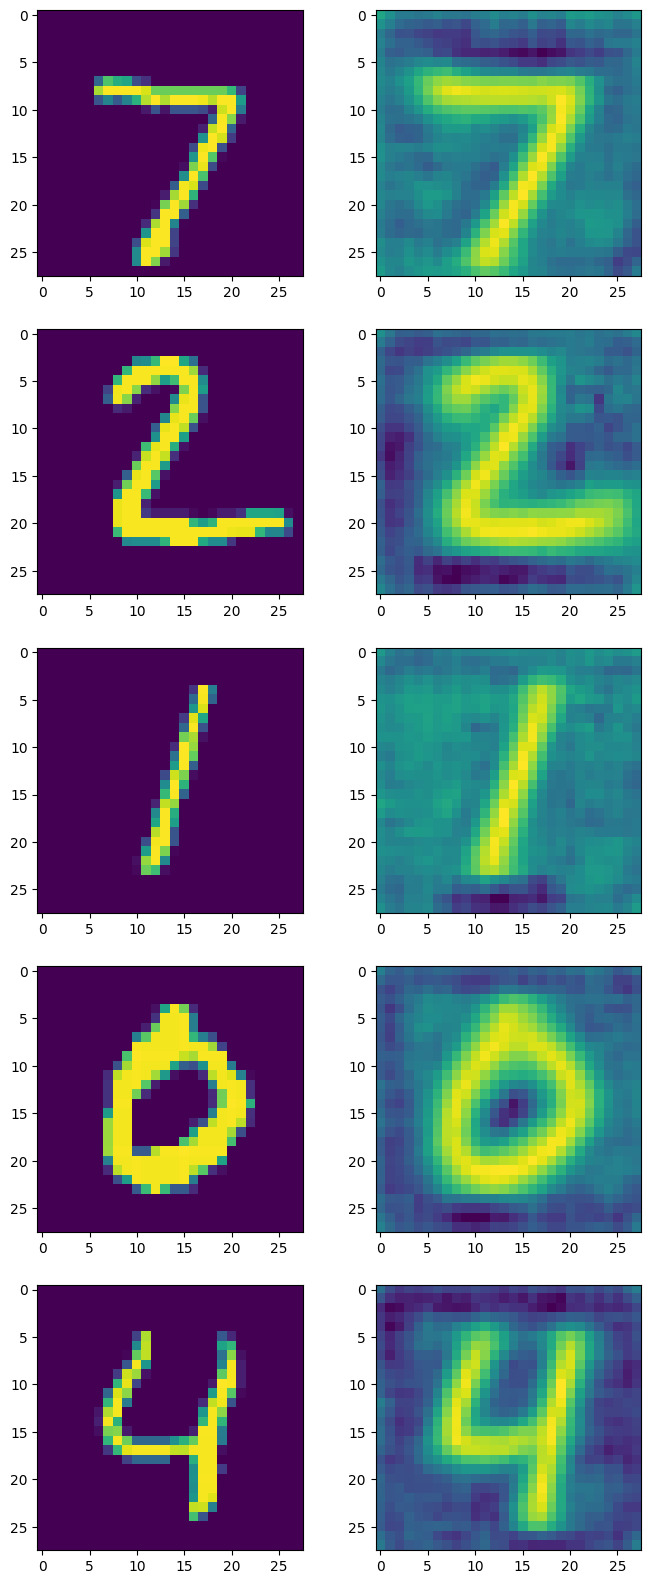

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(torch.permute(gt, (1, 2,0)))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(torch.permute(res, (1, 2,0)))

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

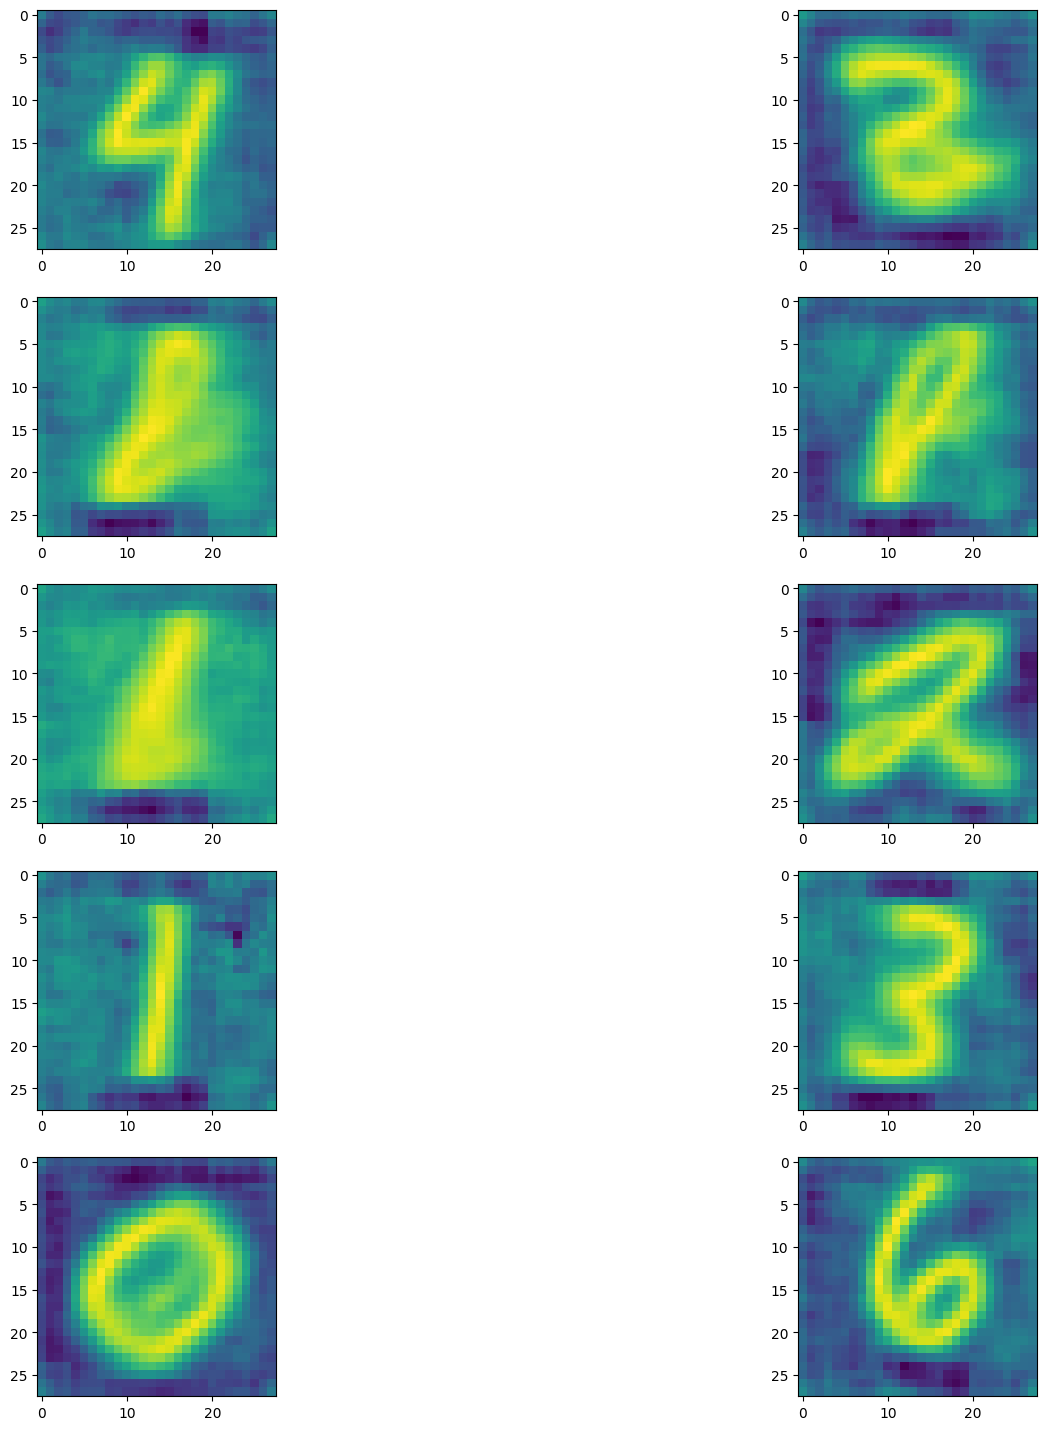

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 32) for i in range(10)])
autoencoder.eval()
with torch.no_grad():
  output  = autoencoder.decode(torch.FloatTensor(z).to(device))
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach()
  plt.imshow(torch.permute(generated, (1, 2,0)))

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_embedded = TSNE(
    n_components=2,
     learning_rate='auto',
     init='random',
      perplexity=3).fit_transform(mus.cpu())

In [ ]:
mus_emb = torch.cat((torch.tensor(X_embedded), labels.view(-1, 1)), dim = 1)

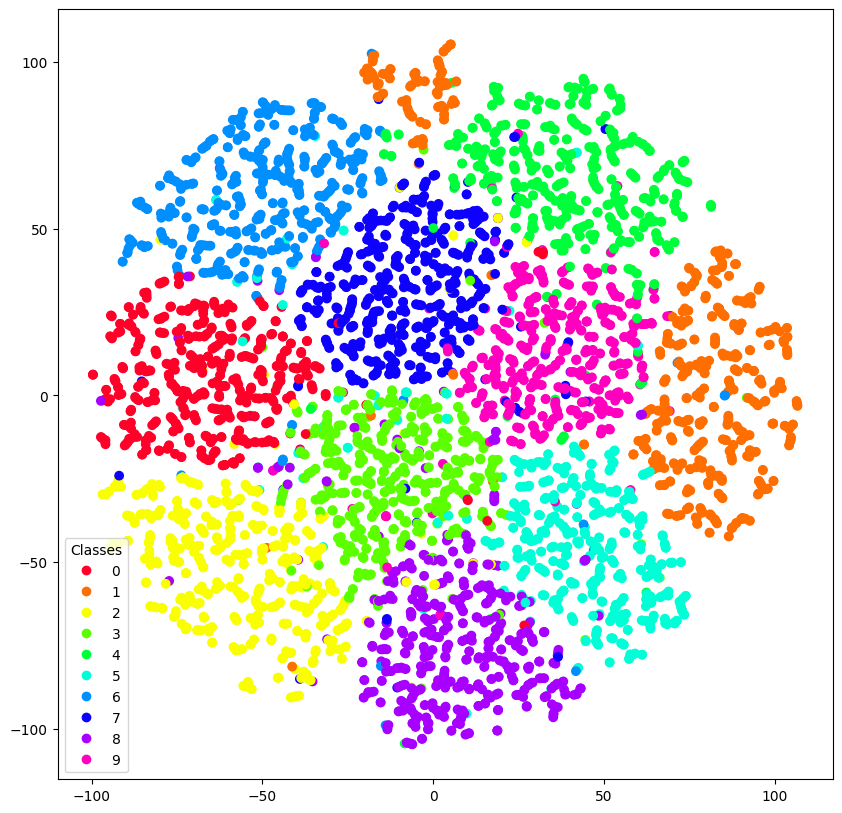

In [ ]:

plt.figure(figsize=(10, 10))
scatter = plt.scatter(mus_emb[:, 0], mus_emb[:, 1], c=mus_emb[:, 2], cmap='gist_rainbow')
plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.show()

## 2.3. Conditional VAE


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

In [ ]:
class CVAE(nn.Module):
    def __init__(self,dim_code=32,im_size=28):
        super(__class__, self).__init__()
        self.fatures=dim_code
        self.encoder = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=3, stride=2,dilation=2,padding=2),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          nn.Conv2d(16, 32,kernel_size=3, stride=2,dilation=2,padding=2),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Conv2d(32, 64, kernel_size=3, stride=2,dilation=2,padding=2),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(64, dim_code, kernel_size=3, stride=2,dilation=2,padding=2),
          nn.ReLU(),
          nn.BatchNorm2d(dim_code),
          nn.Flatten(),
          nn.Linear(in_features=2*2*dim_code, out_features=512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=dim_code*2 )
          )
      
        self.decoder = nn.Sequential(
          nn.Linear(in_features=dim_code, out_features=512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=dim_code*2*2),
          nn.Unflatten(1, (dim_code, 2, 2)),
          nn.ConvTranspose2d(dim_code, 32, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.ConvTranspose2d(128, 1, kernel_size=4, stride=1),
          )
        self.lin_enc=nn.Sequential(
            nn.Linear(im_size*im_size+10,im_size*im_size),
            nn.ReLU(),
            nn.Linear(im_size*im_size, im_size*im_size),
            nn.Unflatten(1, (-1,im_size,im_size))
        )
        self.lin_dec=nn.Sequential(
            nn.Linear(dim_code+10,dim_code),
            nn.ReLU(),
            nn.Linear(dim_code, dim_code)
           
        )

    def encode(self, x, class_num):
        one_hot = torch.nn.functional.one_hot(class_num, 10)
        x = x.view(-1,28*28)
        x = torch.concat([x,one_hot],dim=1)
        x = self.lin_enc(x)
        x = self.encoder(x).view(-1, 2, self.fatures)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :]

        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space          
            return sample
        else:
            return mu
    
    def decode(self, z, class_num):
        one_hot = torch.nn.functional.one_hot(class_num, 10)
        z = torch.concat([z,one_hot],dim=1)

        z = self.lin_dec(z)

        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x,class_num):
        mu, logsigma = self.encode(x,class_num)
        z = self.gaussian_sampler(mu,logsigma)
        #print(z.shape)
        reconstruction = self.decode(z,class_num)
        return mu, logsigma, reconstruction

In [ ]:
criterion = loss_vae

autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []
mus = torch.Tensor()
labels = torch.Tensor()
for epoch in tqdm_notebook(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, (X_batch,Y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device),Y_batch.to(device))
        reconstruction = reconstruction.view(-1,1, 28, 28)
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, (X_batch,Y_batch) in enumerate(val_loader):
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device),Y_batch.to(device))
          reconstruction = reconstruction.view(-1, 1,28,28)
          loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
          if epoch == n_epochs - 1:
            mus = torch.cat((mus, mu.to('cpu')), 0)
            labels = torch.cat((labels, Y_batch), dim=0)

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-183-a5fe14ee8c9b>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

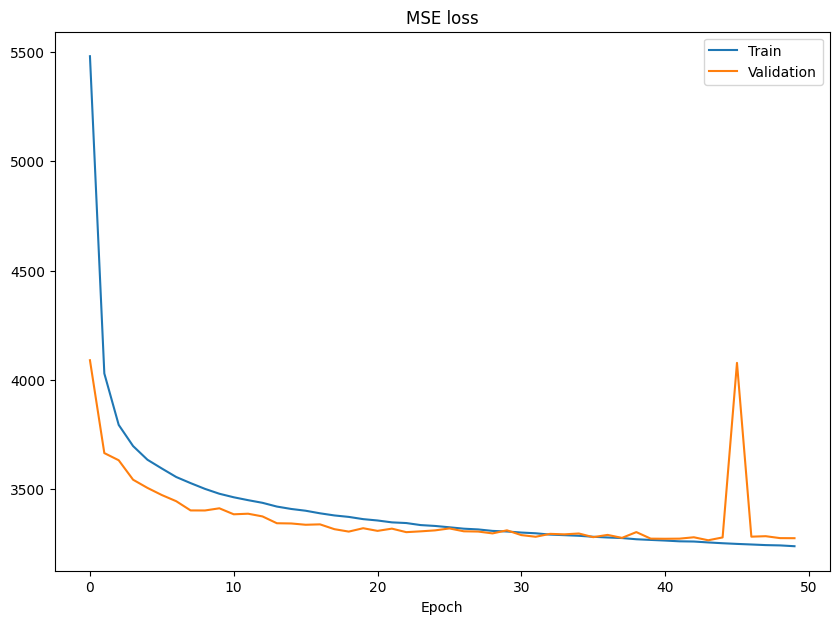

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
  autoencoder.eval()
  with torch.no_grad():
      for i, (X_batch,Y_batch) in enumerate(test_loader):
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device),Y_batch.to(device))
          print(reconstruction.shape)
          result = reconstruction.cpu().detach()#.numpy()
          ground_truth = X_batch#.numpy()
          break

torch.Size([32, 1, 28, 28])


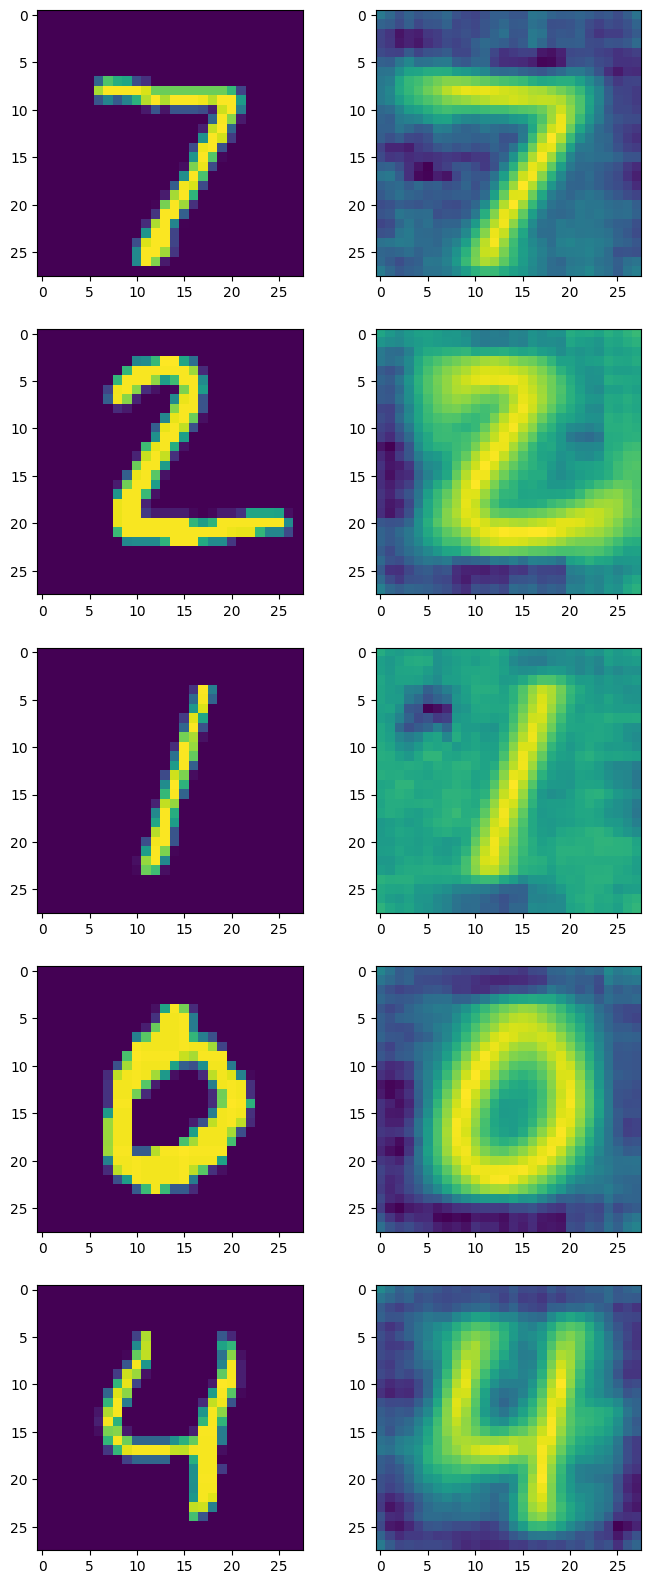

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(torch.permute(gt, (1, 2,0)))
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(torch.permute(res, (1, 2,0)))

Итак, момент истинны, сгенерируем батч шума норм распределения для генерации картинки числа. И добавим список чисел, которые мы хотим сгенерировать, как пример возьмем "1,2,3,4,4,4,8,9,0,7", и посмотрим получится ли у нас сгенерить именно эти числа"

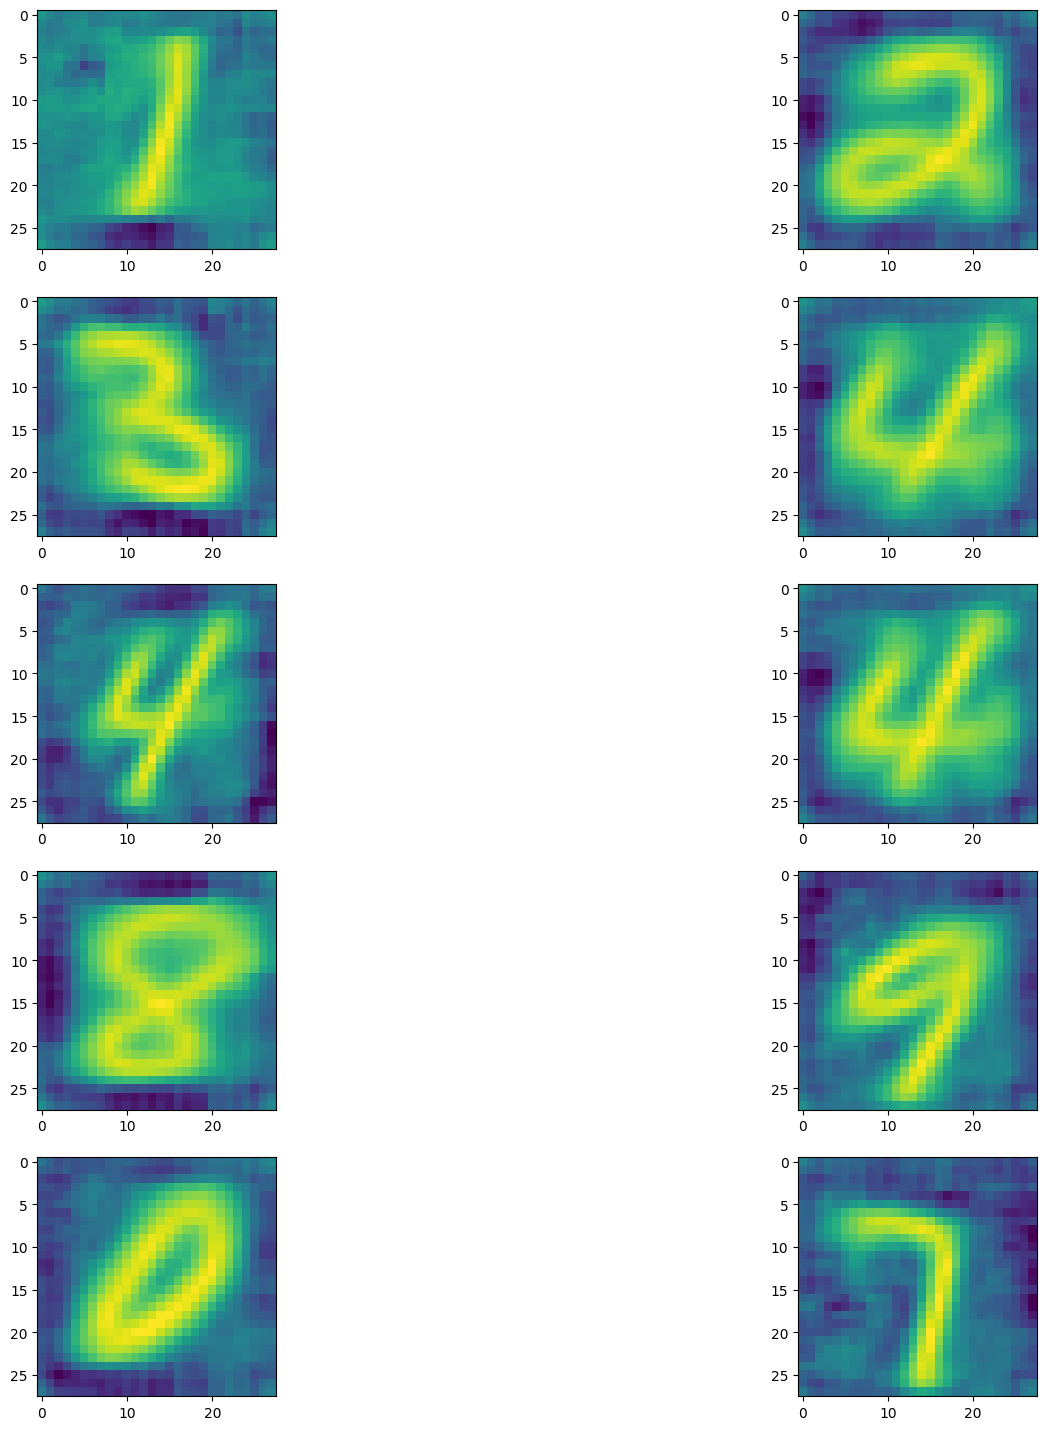

In [ ]:
z = np.array([np.random.normal(0, 1, 32) for i in range(10)])
cls_nums=torch.tensor([1,2,3,4,4,4,8,9,0,7])
autoencoder.eval()
with torch.no_grad():
  output  = autoencoder.decode(torch.FloatTensor(z).to(device),cls_nums.to(device))
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach()
  plt.imshow(torch.permute(generated, (1, 2,0)))

plt.show()

Прекрасно, все цифры до единой совпадают с заданными нами требования по генерации!

In [ ]:

X_embedded = TSNE(
    n_components=2,
     learning_rate='auto',
     init='random',
      perplexity=3).fit_transform(mus.cpu())

Теперь посмотрим какое распределение латентного пространтсва дает CVAE

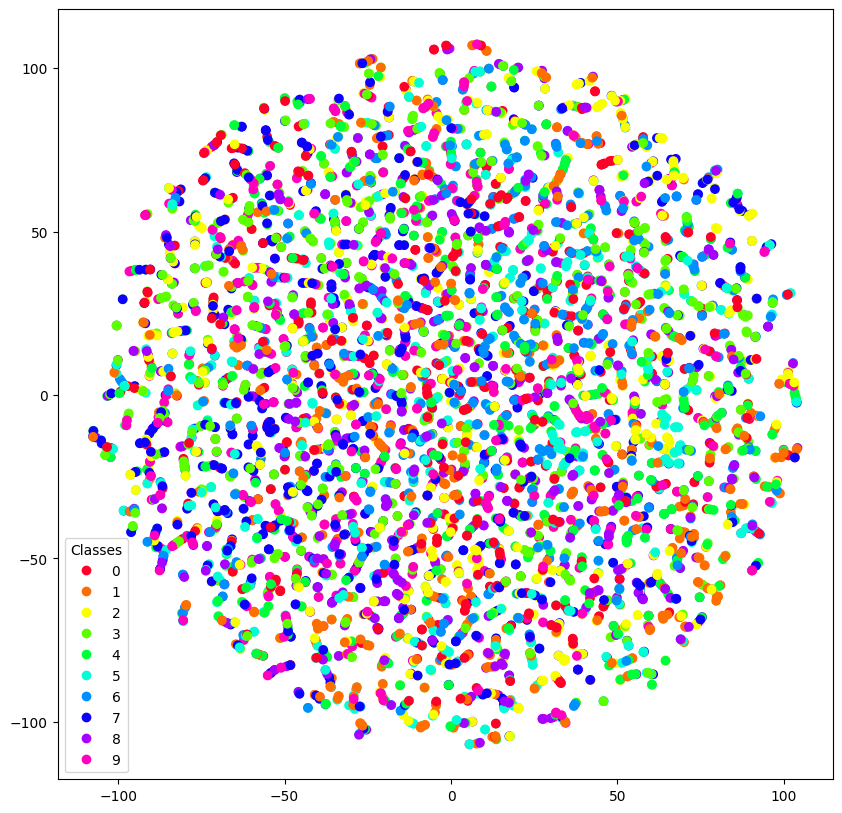

In [ ]:
mus_emb = torch.cat((torch.tensor(X_embedded), labels.view(-1, 1)), dim = 1)
plt.figure(figsize=(10, 10))
scatter = plt.scatter(mus_emb[:, 0], mus_emb[:, 1], c=mus_emb[:, 2], cmap='gist_rainbow')
plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.show()